# Applications of SVD: Image Compression and Image Classification

In this Notebook, we are going to analyse two possible applications of SVD: Image Compression and Image Classification. Both rely on the capability of "summarise" the data on a smaller spaces, keeping at "minimum" the distorsion of data.

# Image Compression

To showcase the potential use of SVD for image compression, we will load a sample image, apply SVD with different parameters and then observe the results.
First, we need to import the module we will use:

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import scipy.linalg as ln
import numpy as np
import os
from PIL import Image
from math import log10, sqrt 

We then load the image
Note: the image is loaded in grayscale for semplicity , but it can be extend to RGB.

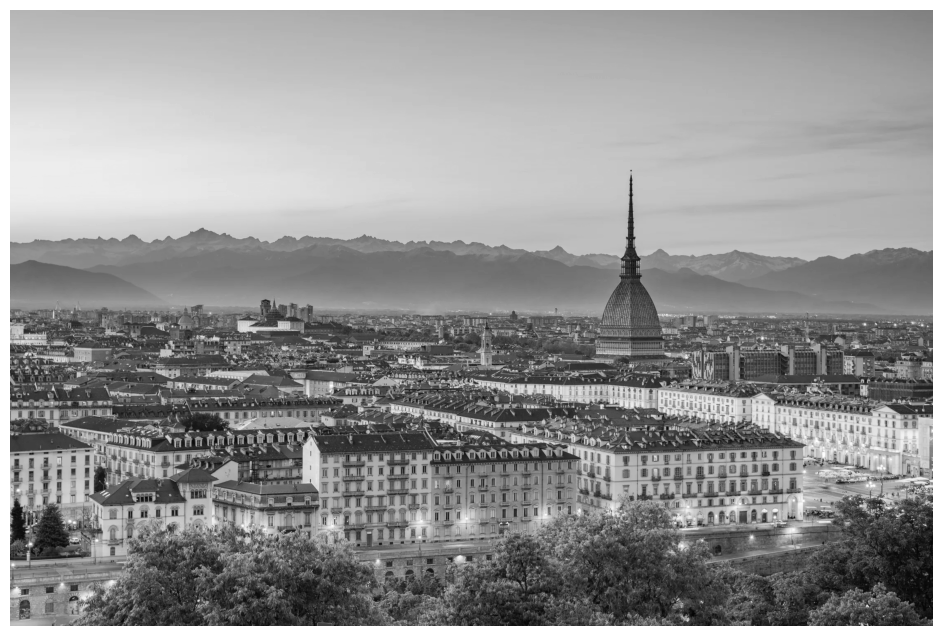

Shape: (1495, 2240)


In [2]:
plt.rcParams['figure.figsize'] = [16, 8]
# Import image
A = imread(os.path.join("SVD_Image_Compression.png"))
X = A.dot([0.299, 0.5870, 0.114]) # Convert RGB to grayscale
img = plt.imshow(X)
# Konvert to gray
img.set_cmap('gray')
plt.axis('off')
plt.show()
# Call image size
print('Shape: %s'%str(X.shape))

We decided to work on the above image, which represents a landscape of Turin. We can now proceed with the application of the SVD with different configurations.
More specifically, we will change k, which represents the dimension of the space we will use to represent the selected image.

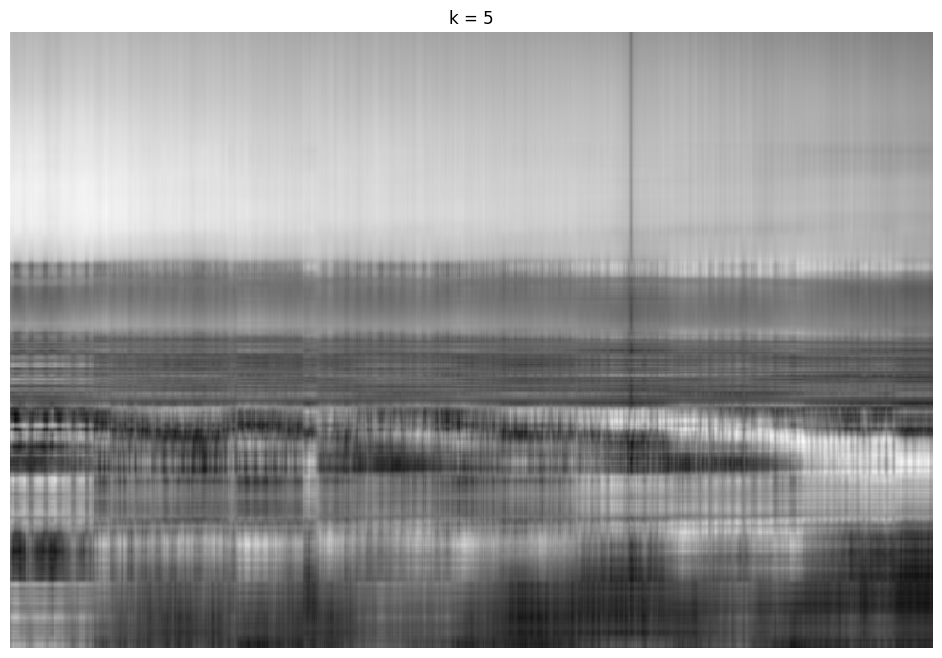

Original Size:
960000
Compressed Size / Original Size:
0.010421875
Compression rate is 1.04%


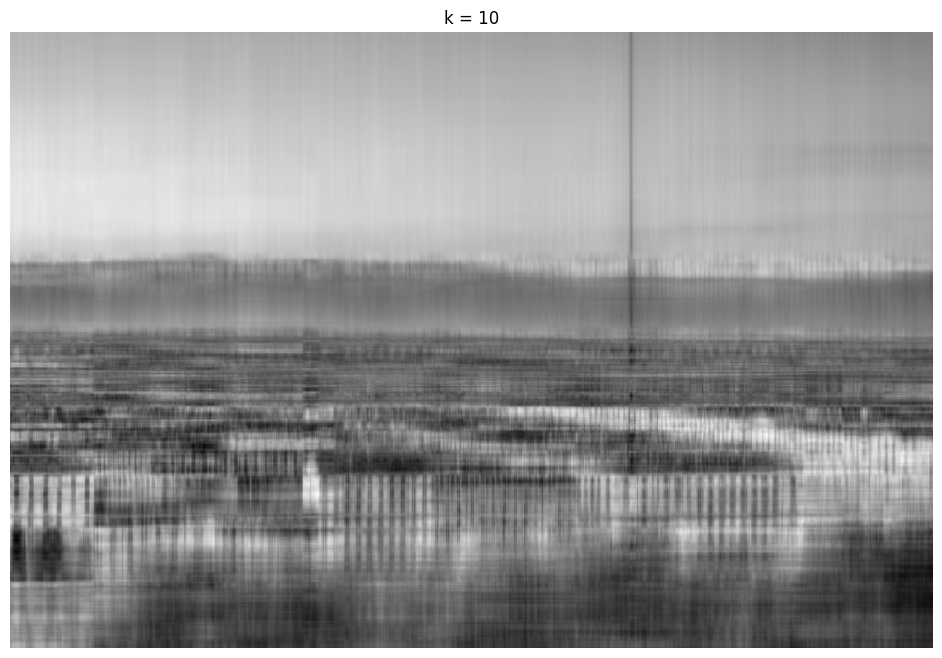

Original Size:
960000
Compressed Size / Original Size:
0.02084375
Compression rate is 2.08%


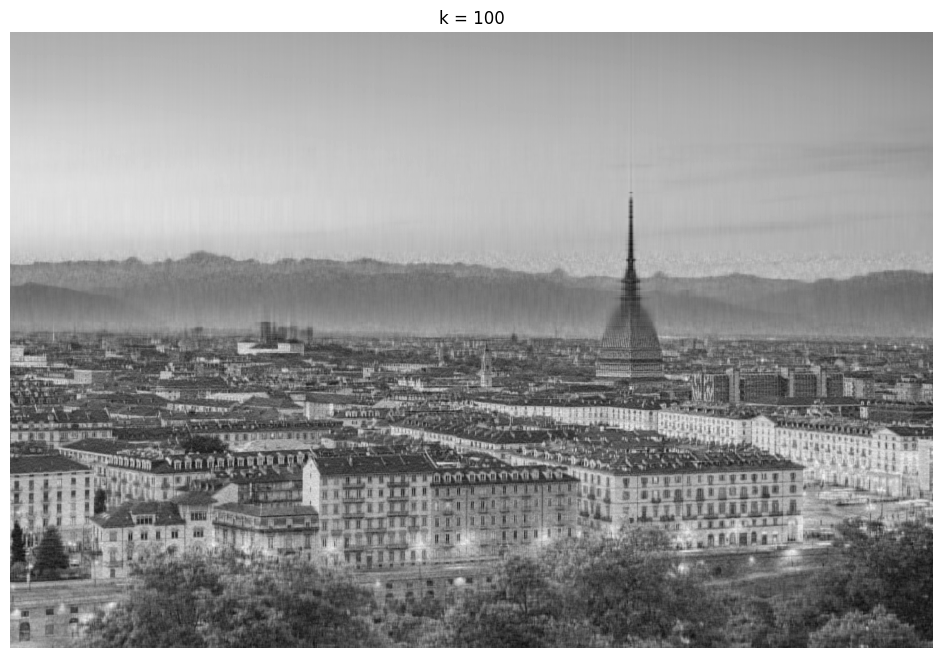

Original Size:
960000
Compressed Size / Original Size:
0.2084375
Compression rate is 20.84%


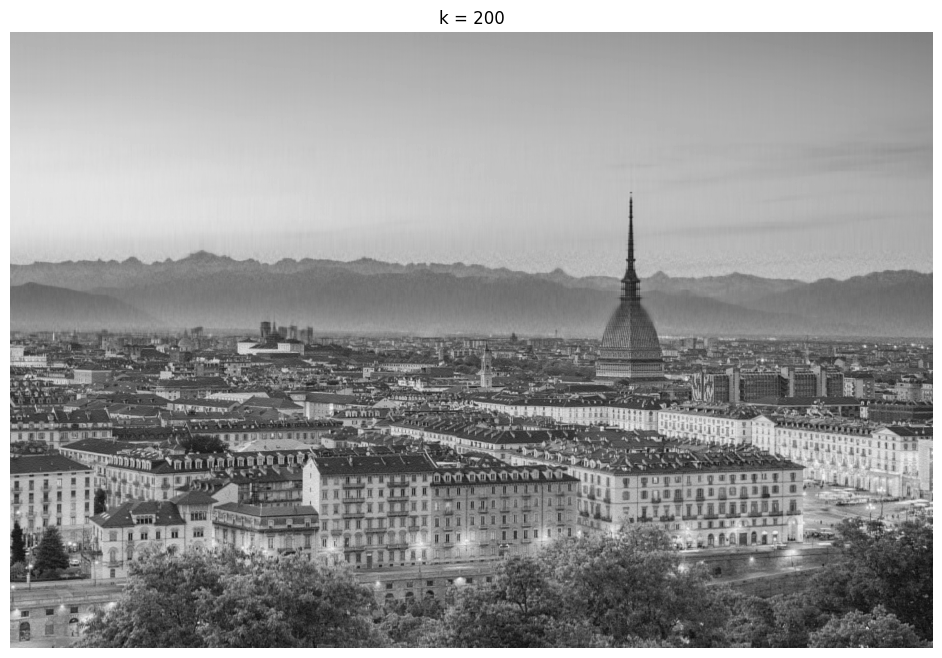

Original Size:
960000
Compressed Size / Original Size:
0.416875
Compression rate is 41.69%


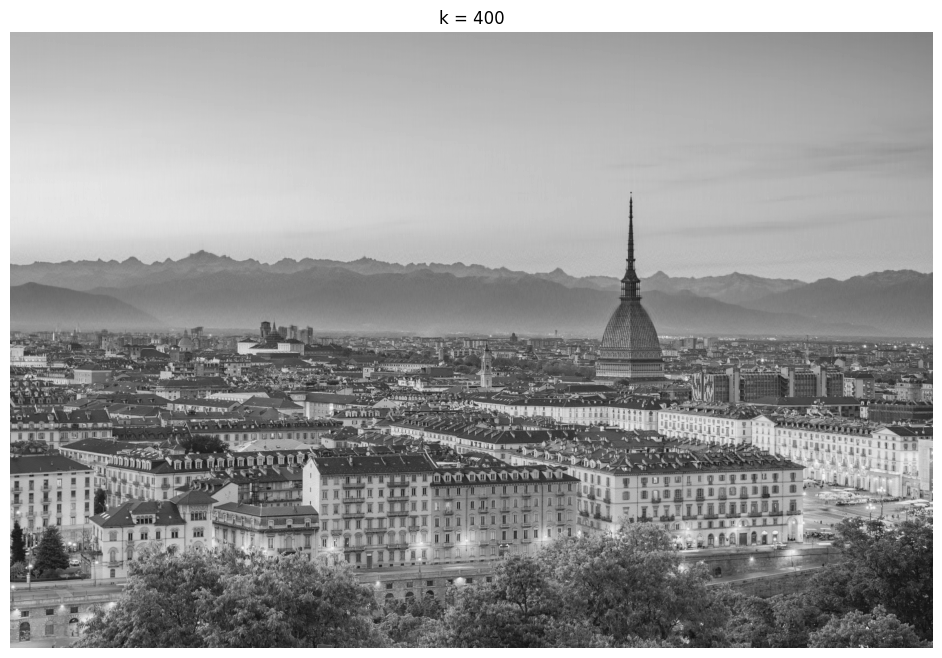

Original Size:
960000
Compressed Size / Original Size:
0.83375
Compression rate is 83.38%


In [3]:
# split the matrix into U, S, VT
U, S, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(S)
m = 800 # Image's width
n = 1200 # Image's height
j = 0
# Try compression with different k:
for k in (5,10,100,200,400):
    # Original size of the image
    originalSize = m * n 
    # Size after compressed
    compressedSize = k * (1 + m + n) 
    # Approximation  of A
    Xapprox = U[:,:k] @ S[0:k,:k] @ VT[:k,:]
    plt.figure(j+1)
    j += 1
    img = plt.imshow(Xapprox)
    img.set_cmap('gray')
    
    plt.axis('off')
    plt.title('k = ' + str(k))
    plt.show() 
    print('Original Size:')
    print(originalSize)
    print('Compressed Size / Original Size:')
    # Estimate the compression rate
    ratio = compressedSize * 1.0 / originalSize
    print(ratio)
    print('Compression rate is ' + str( round(ratio * 100 ,2)) + '%' )  
    # Estimate MQA
    x= X.astype("float")
    y=Xapprox.astype("float")

We can observe that with k=5,10, the image is so compressed that it's almost unrecognisable, so it seems to be not so effective. However, by increasing k up to 100,200, 500 we can notice that the image is much more recognisable.
The application of SVD allowed us to compress an image to a lower quality, which may be interesting for storing purposes especially on the cloud, since this would allow to decrease storage costs.
However, the potential of SVD for compression doesn't terminate here: what makes it special compared to other compression algorithms is the possibility of represent an image by keeping the essential features that characterize it.
This interesting property can be used for image classification purposes and we will explore this concept in the following section.

# Image Classification

To investigate the possible usage of SVD for image classification, we will use the Handwritten Digits USPS (U.S. Postal Service) dataset, which can be downladed by Kaggle at the following link: https://www.kaggle.com/bistaumanga/usps-dataset?select=usps.h5.

The dataset contains 7291 train and 2007 test images of handwritten digits between [0–9] . The images are 16*16 grayscale pixels.
Our goal is to find a way to associate a given picture to one of the ten digits.
Let's import the module we will use during the analysis:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import h5py
import os

We define now the ten labels and load the dataset.

In [5]:

# define class labels
labels = {
    0: "0", 
    1: "1", 
    2: "2", 
    3: "3", 
    4: "4", 
    5: "5", 
    6: "6", 
    7: "7", 
    8: "8",
    9: "9"
}
# load the dataset
with h5py.File(os.path.join(os.getcwd(), 'usps.h5'), 'r') as hf:
        train = hf.get('train')
        test = hf.get('test')
        x_train = pd.DataFrame(train.get('data')[:]).T
        y_train = pd.DataFrame(train.get('target')[:]).T
        x_test = pd.DataFrame(test.get('data')[:]).T
        y_test = pd.DataFrame(test.get('target')[:]).T
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#Output:
#(256, 7291)
#(1, 7291)
#(256, 2007)
#(1, 2007)

(256, 7291)
(1, 7291)
(256, 2007)
(1, 2007)


Let's visualise one of the image composing the training set to better understand the data we are dealing with:

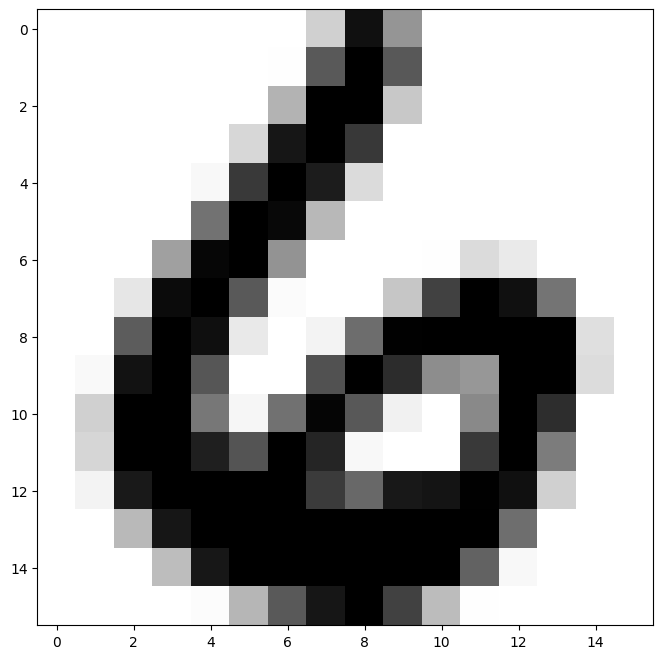

In [6]:
digit_image=x_train[0]
plt.imshow(digit_image.to_numpy().reshape(16,16),cmap='binary')

The sample image depicts a low quality '6' and as expected, it is represented with 16*16 pixels.
Our strategy for image classification is the following:
- We divide the dataset into ten matrices, one for each digit. In each matrix, we represent the training data as columns of the associated matrix.
- We apply the SVD to each matrix. This allows us to represent the A_i matrix with the respective U, S and V matrices.
- The idea behind this classification algorithm is based on the following observation:
  We can say that each digit is made up of distinctive characteristics that allows us to distinguish a digit from other. This "differentiation" is  stored in the firsts vector composing U. Given an unknown digit, we can compare it with the different bases we obtain by considering the first k vectors of U. If an unknown digit can be approximed better with the basis of a specific digit compared to another, this imply that the unknown number can be categorised as that digit.


Let's proceed with the creation of the ten matrices:

In [7]:
#Creation of ten matrices containing records for each digit
alpha_matrices={}
for i in range(10):
    alpha_matrices.update({"A"+str(i):x_train.loc[:,list(y_train.loc[0,:]==i)]})
print(alpha_matrices['A0'].shape)
#(256, 1194)

(256, 1194)


Now, we can apply the SVD algorithm to each matrix A.

In [8]:
left_singular={}
singular_matix={}
right_singular={}
for i in range(10):
    u, s, v_t = svd(alpha_matrices['A'+str(i)], full_matrices=False)
    left_singular.update({"u"+str(i):u})
    singular_matix.update({"s"+str(i):s})
    right_singular.update({"v_t"+str(i):v_t})
print(left_singular['u0'].shape)
#(256, 256)

(256, 256)


Let's observe now the first 20 components of the matrix U obtained by applying the SVD algorithm on A3, representing all the training data related to the digit '3'.

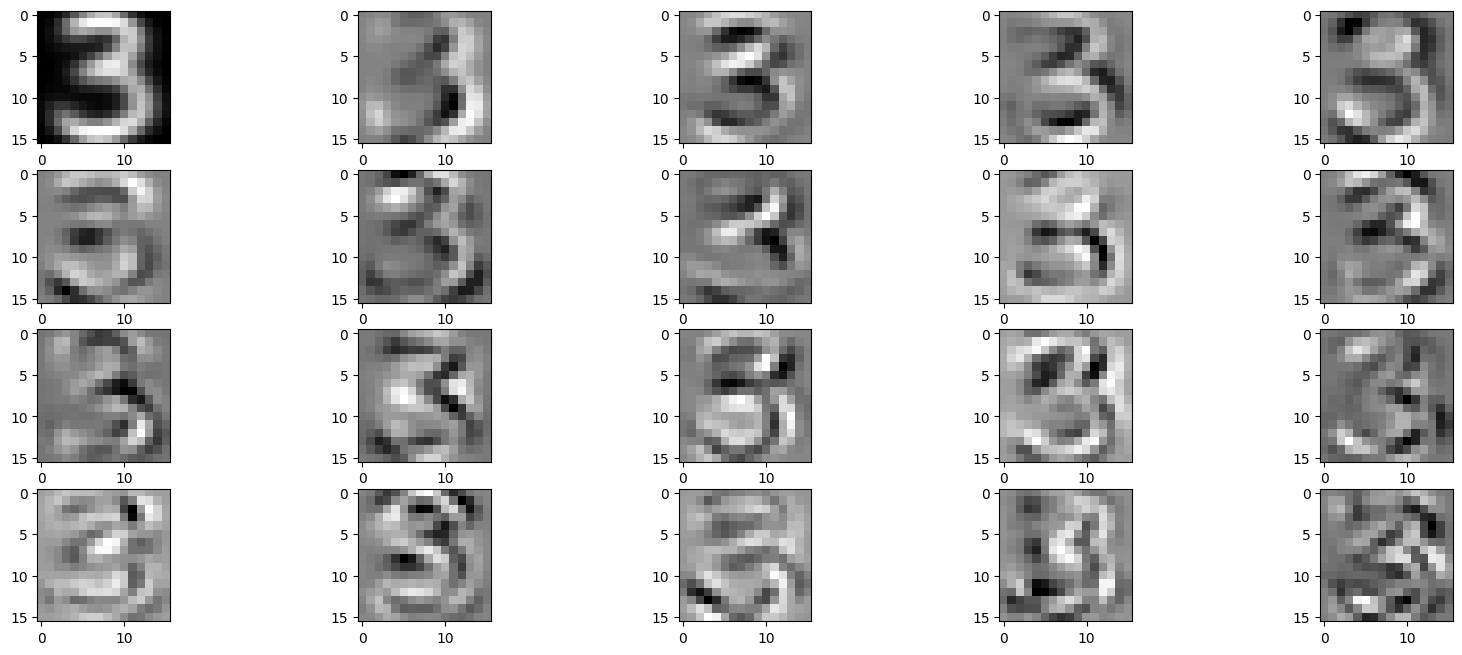

In [9]:
#left_singular[‘u3’]
#right_singular[‘s3]
#singular_matix[‘v_t3]
from math import floor
plt.figure(figsize=(20,10))
columns = 5
n_components=20
for i in range(n_components):
   plt.subplot(floor(n_components/ columns) + 1, columns, i + 1)
   plt.imshow(left_singular["u3"][:,i].reshape(16,16),cmap='binary')

We can notice that all the components represents some "features" of the digit '3'. However, the firsts one are more representative compared to the last ones. This means that the first features contain the major information that charactersize the digit, whereas the others contain less significant variations. We can observe this "relevance" by having a look at the following graph, which plots the singular values in logaritmic scale:

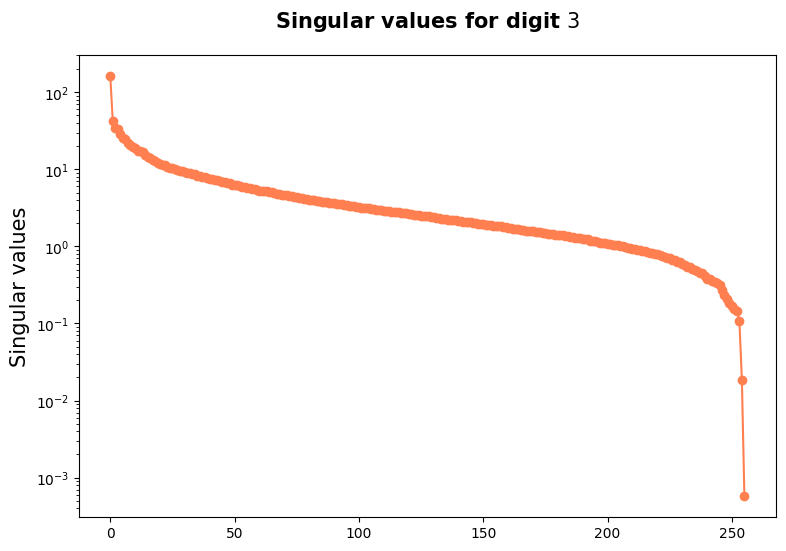

In [10]:
plt.figure(figsize = (9, 6))
plt.plot(singular_matix['s3'], color='coral', marker='o')
plt.title('Singular values for digit $3$',fontsize=15,weight='bold',pad=20)
plt.ylabel('Singular values' ,fontsize=15)
plt.yscale("log")
plt.show()

From a mathematical perspective, to have a better approximation, we need to include the major number possible of singular values with the highest value. 
This is because if we use the Frobenius Norm we observe that:


$
||A-\widetilde{A}||_F=||E||_F^2=tr(EE^T)=tr((\sum_{i=k+1}^{n}\sigma_i u_i v_i^t)(\sum_{i=k+1}^{n}\sigma_j u_j v_j^t)^t)
$

$
=tr(\sum_{i=k+1}^{n}\sum_{j=k+1}^{n}\sigma_i \sigma_j u_i v_i^t v_j u_j) = tr(\sum_{i=k+1}^{n}\sigma^2 u_i u_i^t)=\sum_{i=k+1}^{n}\sigma_i^2
$

This imply a good approximation tries to neglet the vectors associated to singular values with low magnitude, which means it's an approximation that consider more meaningful features.

We need to test now if our intuition based on the Eckart-Young-Mirsky Theorem is correct or not: considering the first k-singular values, which are linked to the first k singular vectors, can we retrieve an acceptable approximation of a digit?
Let's test with different k ( in this case k = 5,6,7,8)


In [11]:
I = np.eye(x_test.shape[0])
kappas=np.arange(5,8)
kappas_length=len(list(kappas))
len_test=x_test.shape[1]
n_test_samples=500
n_bases=10
predictions=np.empty((n_test_samples,0), dtype = int)
for t in list(kappas):
    prediction = []
    for i in range(n_test_samples):
        residuals = []
        for j in range(n_bases):
            u=left_singular["u"+str(j)][:,0:t]
            #measure distance between test digit and approximation in one of the "digit bases"
            res=norm( np.dot(I-np.dot(u,u.T), x_test[i]  )) # * (see section 'mathematical explanation')
            residuals.append(res)
        #the unknown digit is assigned to the digit whose base yield the minimum residual.
        index_min = np.argmin(residuals)
        #store prediction.
        prediction.append(index_min)
        
    prediction=np.array(prediction)
    predictions=np.hstack((predictions,prediction.reshape(-1,1)))
scores=[]
for i in range(len(kappas)):
    score=accuracy_score(y_test.loc[0,:n_test_samples-1],predictions[:,i])
    scores.append(score)

Let's compute the f1 score to understand the accuracy of our algorithm

In [12]:
data={"Number of basis vectors":list(kappas), "accuracy_score":scores}
df=pd.DataFrame(data).set_index("Number of basis vectors")
df

,accuracy_score
Number of basis vectors,
5,0.906
6,0.906
7,0.918


We can notice that by increasing k, we are increasing the number of features considered to classify the unknown digit. However by increasing the number of bases, we are increasing also the dimension of the matrices and thus the cost of computation.


To have a better understanding of the perfomance of our algorithm, we compute now a correlation matrix to identify which digits are misclassified.

In [13]:
pd.set_option('display.max_colwidth',12)
confusion_matrix_df = pd.DataFrame( confusion_matrix(y_test.loc[0,:n_test_samples-1],predictions[:,kappas_length-1]) )
confusion_matrix_df = confusion_matrix_df.rename(columns = labels, index = labels)
confusion_matrix_df

,0,1,2,3,4,5,6,7,8,9
0,116,1,0,0,0,0,1,0,0,1
1,0,67,0,0,0,0,1,0,0,0
2,5,0,40,1,0,1,0,0,3,0
3,0,0,0,25,0,3,0,0,1,0
4,0,1,0,0,31,0,0,0,1,1
5,0,0,0,0,1,24,0,0,1,0
6,1,1,1,0,2,0,41,0,0,0
7,0,0,0,0,0,0,0,34,0,2
8,1,0,0,2,0,0,0,0,40,1
9,0,3,0,0,0,0,0,3,1,41


In [14]:
print(classification_report(y_test.loc[0,:n_test_samples-1],predictions[:,kappas_length-1]))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       119
           1       0.92      0.99      0.95        68
           2       0.98      0.80      0.88        50
           3       0.89      0.86      0.88        29
           4       0.91      0.91      0.91        34
           5       0.86      0.92      0.89        26
           6       0.95      0.89      0.92        46
           7       0.92      0.94      0.93        36
           8       0.85      0.91      0.88        44
           9       0.89      0.85      0.87        48

    accuracy                           0.92       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.92      0.92      0.92       500



Let's have a look to the misclassified elements:

the number of misclassified elements is : 41


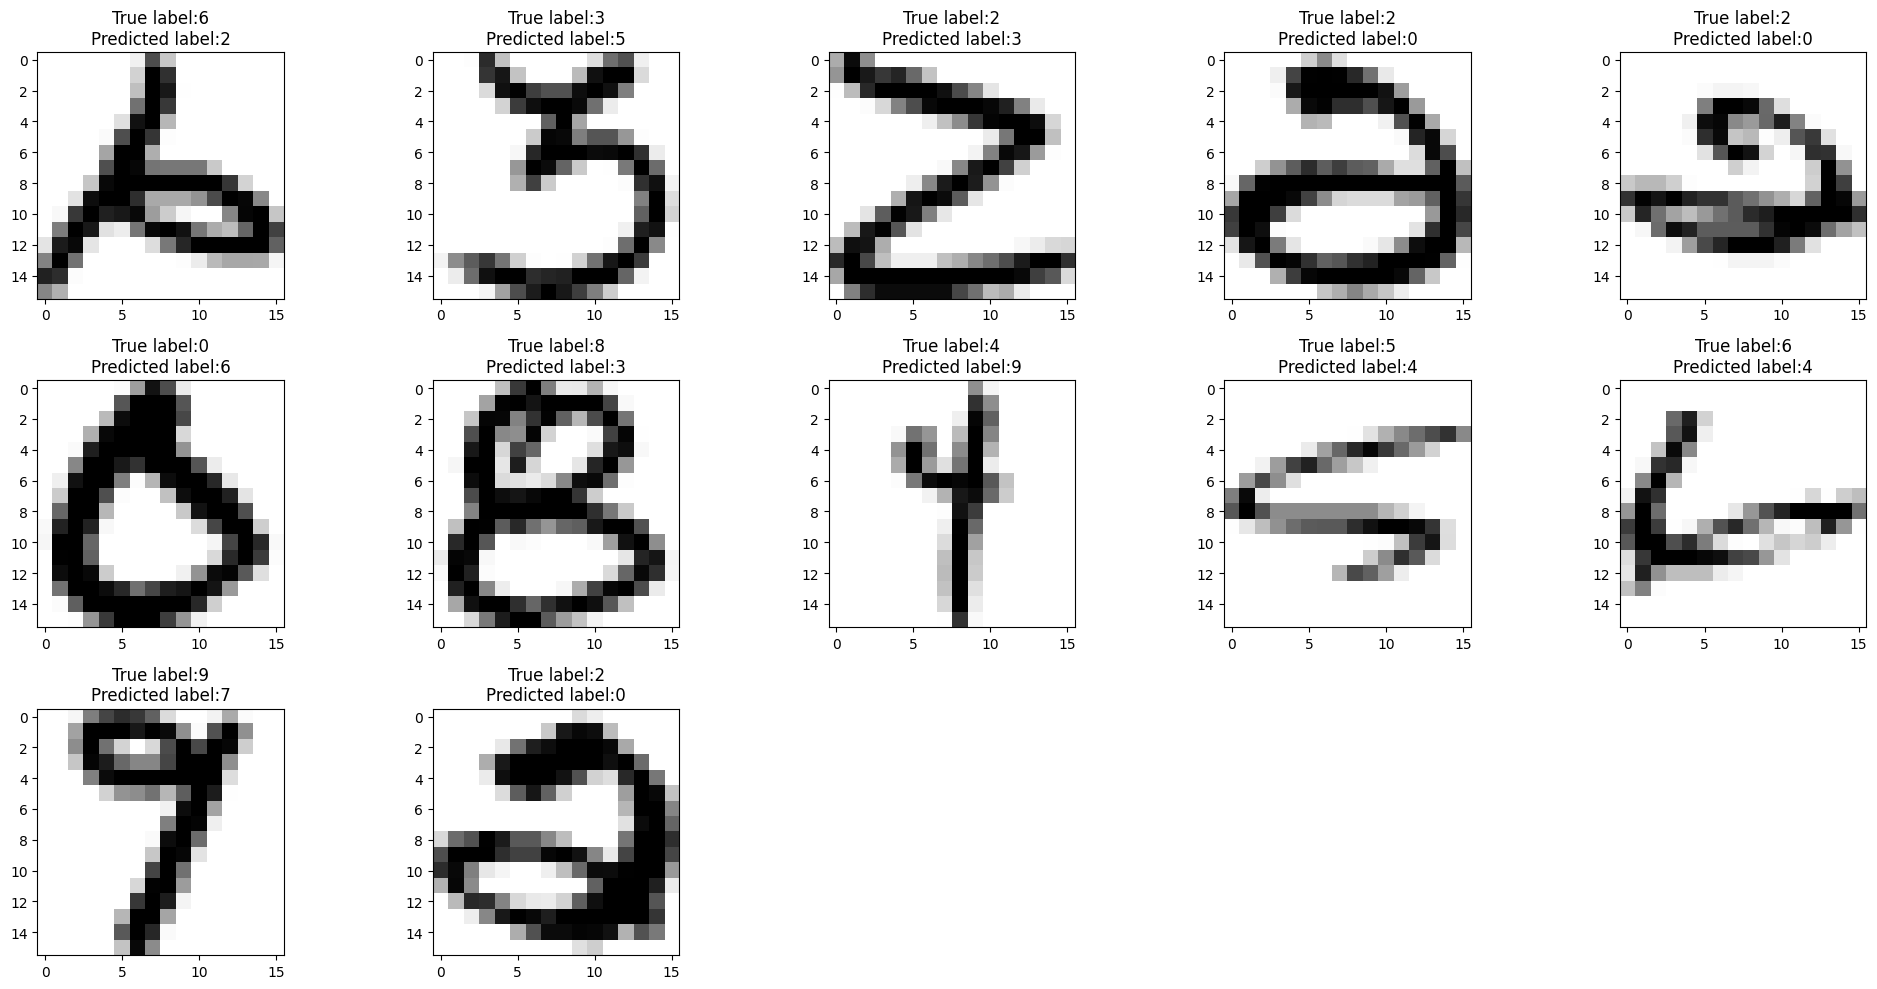

In [15]:
misclassified = np.where(y_test.loc[0,:n_test_samples-1] != predictions[:,kappas_length-1])
print(f"the number of misclassified elements is : {len(misclassified[0])}")
#number of elements we want to inspect.
num_misclassified=12
plt.figure(figsize=(20,10))
columns = 5
for i in range(2,num_misclassified+2):
    misclassified_id=misclassified[0][i]
    image=x_test[misclassified_id]
    
    plt.subplot(floor(10/ columns) + 1, columns, i-1)
    plt.imshow(image.to_numpy().reshape(16,16),cmap='binary')
    plt.title("True label:"+str(y_test.loc[0,misclassified_id]) + '\n'+ "Predicted label:"+str(predictions[misclassified_id,kappas_length-1]))
plt.tight_layout()

We can notice that the misclassified elements are not very well represented, hence we can conclude that our algorithm can recognise an acceptable amount of samples.

# Mathematical explanation

Why this approach works?
To understand why the above algorithm works, we should start with the statement of the Eckart-Young-Mirsky Theorem. The statement is the following:

$
\text{Let A } \epsilon R_{mxn} \text{, for any k <r}  \text{ the truncated decomposition of A, where r is the rank of A}
$

$
A_k= \sum_{i=1}^{k}\sigma_i u_i v_i^t \text{ is the optimal approximation to A.}
$


$
\text{We can prove that the matrix } U_k U_k^t \text{ can solve the least square problem } min ||A - P_k A || \text{ where } P_k=U_k U_k^t \text{is the projection matrix that project A in a  space of dimension k 
}
$



$
\text{and }U_k \text{ is the matrix including the first k columns of U.}
$

$
\text{Proof: Let } U \Sigma V^T \text{be an SVD of A}u_i \text{ the columns of U, } v_i \text{ the columns of V, and } \sigma_i \text{ the singular values of A. If } P_k=U_k U_k^t \text{ then: }
$

$
P_k A = (\sum_{i=1}^{k}u_i u_i^t)(\sum_{j=1}^{n}\sigma_j u_j v_j^t)=\sum_{i=1}^{k}\sum_{j=1}^{n}\sigma_j u_i u_i^t u_j v_j^t=\sum_{i=1}^{k}\sum_{j=1}^{n}\sigma_j u_i \delta_{ij}v_j^t=\sum_{i=1}^{k}\sigma_i u_i v_i^t
$

That is exactly the result that, according to the Eckart-Young-Mirsky Theorem, minimises the least square problem presented.

Now we can rewrite the least square problem as:
$
 min||A - P_k A ||_F=min ||A - U_k U_k^t A||_F= min || A(I - U_k U_k^t)||_F
$
To decide to which digit assign the unknown digit, we choose the digit whose $U_k$ minimise the above function. Since A is costant
for all digits, we can just write:
$
min || (I - U_k U_k^t)||_F
$
which is what we are considering in the previous code snippet.